In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler

Using TensorFlow backend.


In [2]:
cfb_2016 = pd.read_pickle('cfb_2016.pickle')
cfb_2017 = pd.read_pickle('cfb_2017.pickle')
cfb_2018 = pd.read_pickle('cfb_2018.pickle')

In [3]:
df = pd.concat([cfb_2016, cfb_2017, cfb_2018])

In [4]:
df.reset_index(drop=True, inplace=True)

In [5]:
df.dtypes

Name            object
Pos             object
Yr              object
Ht              object
Wt              object
Kickoffs       float64
Punts          float64
TD             float64
FG             float64
1XP            float64
2XP            float64
Points         float64
Rush Yards     float64
Pass Yards     float64
Recv.          float64
Int.           float64
Solo           float64
Sacks          float64
Att            float64
Comp           float64
Passing TD     float64
Passing Int    float64
Drafted         object
dtype: object

In [6]:
df = df.loc[(df['Wt'] != '-')]
df['Wt'] = pd.to_numeric(df['Wt'])

In [7]:
df = df.loc[(df['Ht'] != '-')]
df = df.loc[(df['Ht'] != 0)]

In [8]:
height_list = []

for height in df['Ht']:
    
    heights = str(height).split('-')
    height_list.append(int(heights[0]) * 12 + int(heights[-1]))

In [9]:
df.reset_index(drop=True, inplace=True)
df['Ht'] = pd.Series(height_list)

In [10]:
df = df.loc[(df['Pos'] != '-')]
df.reset_index(drop=True, inplace=True)

In [11]:
df['Pos'].value_counts()

WR      3072
OL      3060
LB      2426
DB      2099
DL      1672
RB      1356
TE      1280
QB      1061
S        844
DE       843
CB       824
DT       610
K        433
P        395
LS       380
FB       294
OLB      234
PK       234
OT       215
OG       182
ILB      169
TB       109
ATH      106
SN        85
C         81
DS        52
NT        39
FS        27
MLB       18
WLB       17
STUD      16
SS        14
SLB       12
HB        11
NG        10
BUCK       5
ROV        2
FL         1
SE         1
Name: Pos, dtype: int64

In [12]:
df.reset_index(drop=True, inplace=True)
drafted = df.loc[(df['Drafted']=='Yes')]
drafted['Pos'].value_counts()

WR     77
OL     72
DB     71
LB     52
DL     50
RB     49
DE     40
TE     37
CB     34
QB     28
DT     23
S      22
OLB    10
OT      8
ILB     8
P       6
OG      5
FB      5
TB      5
C       3
K       3
SS      2
HB      2
SN      1
ATH     1
PK      1
WLB     1
FS      1
LS      1
SLB     1
MLB     1
Name: Pos, dtype: int64

In [13]:
categorized_list = []
defensive_zone = ['CB', 'S']
defensive_line = ['DB', 'DE', 'DL', 'DT',] 
linebackers = ['LB', 'OLB', 'ILB']
receivers = ['WR', 'TE']
running_back = ['RB']
qb = ['QB']
offensive_lineman = ['OL', 'OT']

for position in df['Pos']:
    
    if position in defensive_line:
        categorized_list.append('Defense')
    elif position in receivers:
        categorized_list.append('Receiver')
    elif position in defensive_zone:
        categorized_list.append('Defensive Zone')
    elif position in qb:
        categorized_list.append('Quarterback')
    elif position in running_back:
        categorized_list.append('Running Back')
    elif position in linebackers:
        categorized_list.append('linebackers')
    elif position in offensive_lineman:
        categorized_list.append('Offensive Lineman')
    else:
        categorized_list.append('Other')

In [14]:
df['Category'] = pd.Series(categorized_list)

In [16]:
main_data = df.loc[(df['Category'] != 'Other')]
main_data

,Name,Pos,Yr,Ht,Wt,Kickoffs,Punts,TD,FG,1XP,...,Recv.,Int.,Solo,Sacks,Att,Comp,Passing TD,Passing Int,Drafted,Category
1,Jaleel Awini,WR,SR,74,215.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,No,Receiver
2,Chidobe Awuzie,DB,SR,72,205.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,53.0,4.0,0.0,0.0,0.0,0.0,Yes,Defense
3,David Bagby,WR,SR,72,180.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,Receiver
5,Mo Bandi,OL,FR,77,270.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,Offensive Lineman
6,Sam Bennion,OLB,FR,77,230.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,linebackers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22282,Davon Wells-Ross,DE,FR,77,205.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,Defense
22283,Miles Williams,CB,FR,73,192.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,No,Defensive Zone
22284,Logan Wilson,LB,JR,74,250.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,57.0,2.0,0.0,0.0,0.0,0.0,No,linebackers
22286,Ben Wisdorf,LB,JR,73,230.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,No,linebackers


In [29]:
!mkdir data

In [18]:
main_data.to_pickle('data/df.pickle')

In [17]:
df['Category'].value_counts()

Defense              5224
Receiver             4352
Offensive Lineman    3275
linebackers          2829
Other                2524
Defensive Zone       1668
Running Back         1356
Quarterback          1061
Name: Category, dtype: int64

In [24]:
df.loc[(df['Category'] == 'Offense')]

,Name,Pos,Yr,Ht,Wt,Kickoffs,Punts,TD,FG,1XP,...,Recv.,Int.,Solo,Sacks,Att,Comp,Passing TD,Passing Int,Drafted,Category
1,Jaleel Awini,WR,SR,74,215.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,No,Offense
3,David Bagby,WR,SR,72,180.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,Offense
10,Brian Boatman,TE,SR,75,225.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,Offense
11,Bryce Bobo,WR,JR,74,190.0,0.0,0.0,2.0,0.0,0.0,...,548.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,No,Offense
12,Chris Bounds,TE,FR,76,245.0,0.0,0.0,0.0,0.0,0.0,...,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,No,Offense
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22265,Jared Scott,WR,SO,78,225.0,0.0,0.0,0.0,0.0,0.0,...,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,Offense
22269,Justyn Stindt,WR,FR,74,192.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,Offense
22273,Xazavian Valladay,RB,FR,72,191.0,0.0,0.0,3.0,0.0,0.0,...,35.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,No,Offense
22281,Nate Weinman,TE,FR,79,260.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,Offense


In [16]:
zone['Pos'].value_counts()

S     844
CB    824
Name: Pos, dtype: int64

In [19]:
X = zone[['Ht', 'Wt', 'Int.', 'Solo', 'Sacks']]
y = zone['Drafted']

In [20]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                            test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                            test_size=0.2, random_state=42)

In [21]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train,y_train)

In [22]:
logistic = LogisticRegression(C=100000, verbose=True)
logistic.fit(X_resampled, y_resampled)

[LibLinear]

//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=True,
                   warm_start=False)

In [23]:
logistic.predict(X_val)

array(['No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'Yes', 'No', 'No', 'No', 'No', 'Yes', 'No', 'Yes', 'Yes', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes',
       'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'No',
       'Yes', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes',
       'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'No',
       'Yes', 'No', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No',
       'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'Yes', 'No', 'No',

In [24]:
logistic.score(X_val, y_val)

0.8202247191011236

In [29]:
conf_mat = confusion_matrix(y_true=y_val, y_pred=logistic.predict(X_val))
print(conf_mat)



[[214  47]
 [  1   5]]


In [12]:
wr = df.loc[(df['Pos'] == 'WR')]
wr.reset_index(drop=True, inplace=True)

In [13]:
wr['Drafted'].value_counts()

No     2995
Yes      77
Name: Drafted, dtype: int64

In [14]:
wr_X = wr[['Yr', 'Ht', 'Wt', 'TD', '2XP', 'Points', 'Recv.']]
wr_y = wr['Drafted']

In [15]:
wrX = pd.get_dummies(wr_X)

In [16]:
X = df[['Pos', 'Yr', 'Ht', 'Wt', 'Kickoffs', 'Punts', 'TD', 'FG', '1XP',
       '2XP', 'Points', 'Rush Yards', 'Pass Yards', 'Recv.', 'Int.', 'Solo',
       'Sacks', 'Att', 'Comp', 'Passing TD', 'Passing Int']]
y = df['Drafted']

In [17]:
wrX_train_val, wrX_test, wr_y_train_val, wr_y_test = train_test_split(wrX, wr_y, 
                                                            test_size=0.2, random_state=42)
wrX_train, wrX_val, wr_y_train, wr_y_val = train_test_split(wrX_train_val, wr_y_train_val, 
                                                            test_size=0.2, random_state=42)


In [18]:
randomforest = RandomForestClassifier(n_estimators=100)
randomforest.fit(wrX_train, wr_y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [22]:
y_pred = randomforest.predict(wrX_val)

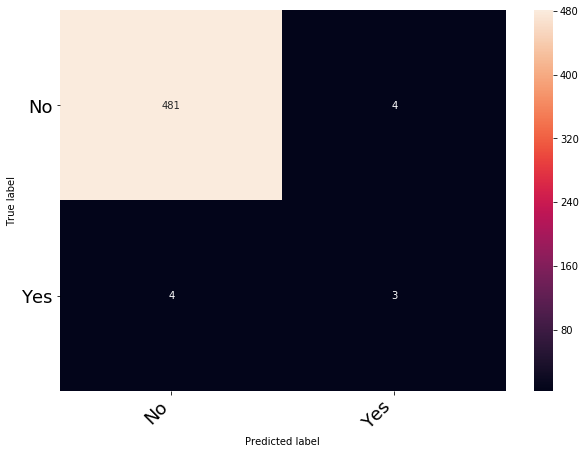

In [25]:
conf_mat = confusion_matrix(y_true=wr_y_val, y_pred=y_pred)
cm = print_confusion_matrix(conf_mat, ['No', 'Yes'])

In [26]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [ ]:
clf = XGBClassifier(max_depth=2,n_estimators=50).fit(wrX_train, wr_y_train)